# 2023-08-09__Poisson_cquantile_upperbound

In [1]:
1

1

In [2]:
using WithFeedback

In [3]:
@withfb using Revise

using Revise … ✔ (1.9 s)


In [4]:
@withfb using GlobalMacros
@withfb using Units

using GlobalMacros … ✔
using Units … ✔


In [5]:
@withfb using PyPlot
@withfb using Sciplotlib
@withfb using PhDPlots

using PyPlot … ✔ (16.4 s)
using Sciplotlib … ✔ (11.1 s)
using PhDPlots … ✔


In [4]:
@withfb using Distributions

using Distributions … ✔ (1.5 s)


In [7]:
f(x) = cquantile(Poisson(x), 1E-14)

f (generic function with 1 method)

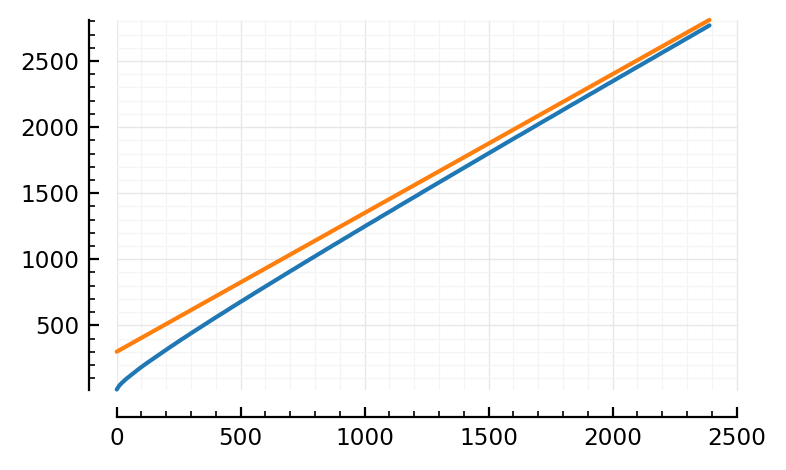

In [43]:
x = 1:10:(4*600)
g(x) = 300+1.05*x
Sciplotlib.plot(x, f.(x))
Sciplotlib.plot(x, g.(x));

In [44]:
x = 1:10:(4*60000)
all(f.(x) .< g.(x))

true

In [13]:
using Nto1AdEx

In [14]:
out = Nto1AdEx.sim(6500, 10*seconds);

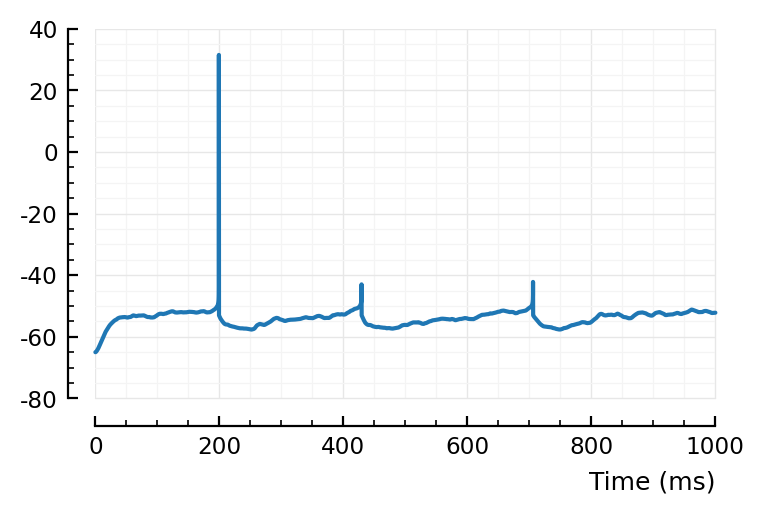

In [24]:
PhDPlots.plotsig(out.V / mV, [0, 1000], ms);

In [23]:
@time Nto1AdEx.sim(6500, 10*seconds);

  0.067683 seconds (13.03 k allocations: 31.572 MiB, 21.20% gc time)


🤯

## Measuring compilation time

- re-pre-compiling the module
- first time running the func

In [3]:
@time using Nto1AdEx

[ Info: Precompiling Nto1AdEx [368485ca-63bc-4029-854f-349d2205662c]


  0.727026 seconds (195.55 k allocations: 13.672 MiB, 2.12% gc time, 26.00% compilation time: 19% of which was recompilation)


In [4]:
@time using Units

  0.000880 seconds (377 allocations: 25.625 KiB)


In [5]:
@time Nto1AdEx.sim(6500, 10*seconds);

  0.041351 seconds (13.03 k allocations: 31.572 MiB, 27.28% gc time)


In [7]:
@time Nto1AdEx.sim(6500, 10*seconds);

  0.039387 seconds (13.03 k allocations: 31.572 MiB, 31.90% gc time)


:OOOOOO holy damn!\
Changing laptop battery mode from 'better battery' to 'best performance,\
changes sim time from ~0.15 sec to 0.026 sec.

Gotta re-do Brian timings on 'best performance'.

(Can change setting not only by clicking battery (which doesn't always work 🙄), but also
start > settings > power & bat > power mode.\ 
(https://support.microsoft.com/en-us/windows/change-the-power-mode-for-your-windows-pc-c2aff038-22c9-f46d-5ca0-78696fdf2de8#Category=Windows_11)

Hm, how can I trigger pkg recomp again?
Maybe not using Revise (it's too fast now, lol (when I add method or change a param).

Ok, that did it. (I restarted nb, didn't load Revise).
Then:
```
[ Info: Precompiling Nto1AdEx [368485ca-63bc-4029-854f-349d2205662c]

  0.727026 seconds (195.55 k allocations: 13.672 MiB, 2.12% gc time, 26.00% compilation time: 19% of which was recompilation)
```
First run time of sim:
```
 0.041351 seconds (13.03 k allocations: 31.572 MiB, 27.28% gc time)
```
hm, is this cached?

After clearing `C:\Users\tfiers\.julia\compiled\v1.9\Nto1AdEx`
(had to stop this jl kernel)

In [2]:
@time using Nto1AdEx

[ Info: Precompiling Nto1AdEx [368485ca-63bc-4029-854f-349d2205662c]


  0.679249 seconds (193.93 k allocations: 13.567 MiB, 1.45% gc time, 24.78% compilation time: 10% of which was recompilation)


In [3]:
@time using Units

  0.000860 seconds (377 allocations: 25.625 KiB)


In [4]:
@time Nto1AdEx.sim(6500, 10*seconds);

  0.037517 seconds (13.03 k allocations: 31.572 MiB, 30.89% gc time)


In [6]:
@time Nto1AdEx.sim(6500, 10*seconds);

  0.035507 seconds (13.03 k allocations: 31.572 MiB, 28.18% gc time)


Ok. incredible.

Also, there's just no compilation cost on first function call?

One last try: emptying module.

In [2]:
@time using Nto1AdEx

[ Info: Precompiling Nto1AdEx [368485ca-63bc-4029-854f-349d2205662c]


  0.657741 seconds (193.18 k allocations: 13.418 MiB, 2.26% gc time, 27.71% compilation time: 9% of which was recompilation)


(This was precompiling an empty module (just commented out lines))

Restarting and nb and re-filling in:\
(but adding a comment line to not hit cache, maybe)

In [2]:
@time using Nto1AdEx

[ Info: Precompiling Nto1AdEx [368485ca-63bc-4029-854f-349d2205662c]


  0.693661 seconds (194.14 k allocations: 13.590 MiB, 1.51% gc time, 26.59% compilation time: 11% of which was recompilation)


What the hell? Mad? Is this real?

In [4]:
@time Nto1AdEx.sim(6500, 10*seconds);

  0.038055 seconds (13.03 k allocations: 31.572 MiB, 30.97% gc time)


Ok, one last test. A new module. Maybe here?

### New module

In [10]:
module Nto1AdEx2

using GlobalMacros
using Units
using Random

@typed begin
    # AdEx LIF neuron params (cortical RS)
    C  = 104  * pF
    gₗ = 4.3  * nS
    Eₗ = -65  * mV
    Vₜ = -52  * mV
    Δₜ = 0.8  * mV
    Vₛ =  40  * mV
    Vᵣ = -53  * mV
    a  = -0.8 * nS
    b  =  65  * pA
    τw =  88  * ms
    # Conductance-based synapses
    Eₑ =   0 * mV
    Eᵢ = -80 * mV
    τg =   7 * ms
    # Simulation timestep
    Δt = 0.1 * ms
    # Input firing rate distribution
    μₓ = 4 * Hz
    σ = sqrt(0.6)
    μ = log(μₓ / Hz) - σ^2 / 2
end

const T = Float64

@kwdef mutable struct Neuron
    V    ::T = Eₗ
    w    ::T = 0 * pA
    gₑ   ::T = 0 * nS
    gᵢ   ::T = 0 * nS
    DₜV  ::T = 0 * mV/second
    Dₜw  ::T = 0 * pA/second
    Dₜgₑ ::T = 0 * nS/second
    Dₜgᵢ ::T = 0 * nS/second
end

# Calculate & store derivatives
f!(n::Neuron) = let (; V, w, gₑ, gᵢ) = n
    # Synaptic current
    Iₛ = gₑ*(V - Eₑ) + gᵢ*(V - Eᵢ)
    # Diffeqs
    n.DₜV  = (-gₗ*(V - Eₗ) + gₗ*Δₜ*exp((V-Vₜ)/Δₜ) - Iₛ - w) / C
    n.Dₜw  = (a*(V - Eₗ) - w) / τw
    n.Dₜgₑ = -gₑ / τg
    n.Dₜgᵢ = -gᵢ / τg
end

eulerstep!(n::Neuron) = begin
    n.V  += n.DₜV  * Δt
    n.w  += n.Dₜw  * Δt
    n.gₑ += n.Dₜgₑ * Δt
    n.gᵢ += n.Dₜgᵢ * Δt
end

has_spiked(n::Neuron) = n.V > Vₛ
on_self_spike!(n::Neuron) = begin
    n.V = Vᵣ
    n.w += b
end

include("../pkg/Nto1AdEx/src/poisson.jl")

struct Spike
    time   ::Float64
    source ::Int
end
Base.isless(x::Spike, y::Spike) = x.time < y.time

spikevec(src_id, times) = [Spike(t, src_id) for t in times]

multiplex(spiketrains) = begin
    # Join spiketimes of different trains into one sorted stream of Spikes
    spikevecs = [spikevec(i, times) for (i, times) in enumerate(spiketrains)]
    spikes = reduce(vcat, spikevecs)
    sort!(spikes)
end

sim(N, duration, seed=1, wₑ=14*pS, wᵢ=4*wₑ) = begin
    Random.seed!(seed)
    num_steps = round(Int, duration / Δt)
    t = 0 * second
    n = Neuron()
    V = Vector{T}(undef, num_steps)
    spiketimes = T[]
    Nₑ = round(Int, N * 4/5)
    rates = exp.(randn(N) .* σ .+ μ) .* Hz
    trains = [poisson_spikes(r, duration) for r in rates]
    spikes = multiplex(trains)
    # Index to keep track of input spikes processed
    j = 1
    for i in 1:num_steps
        # Process incoming spikes
        while j < length(spikes) && spikes[j].time < t
            # New spike arrival
            spike = spikes[j]
            if spike.source ≤ Nₑ
                n.gₑ += wₑ
            else
                n.gᵢ += wᵢ
            end
            j += 1
        end
        # Update neuron state variables (calc & apply diffeqs)
        f!(n)
        eulerstep!(n)
        if has_spiked(n)
            on_self_spike!(n)
            push!(spiketimes, t)
        end
        V[i] = n.V
        t += Δt
    end
    spikerate = length(spiketimes) / duration
    return (; V, spiketimes, rates, trains, Nₑ, spikerate, wₑ)
end

end


Main.Nto1AdEx2

In [12]:
@time using .Nto1AdEx2

  0.000009 seconds (9 allocations: 416 bytes)


In [13]:
using Units

In [14]:
@time Nto1AdEx2.sim(6500, 10*seconds);

  0.042777 seconds (13.03 k allocations: 31.572 MiB, 23.99% gc time)


In [16]:
@time Nto1AdEx2.sim(6500, 10*seconds);

  0.026069 seconds (13.03 k allocations: 31.572 MiB)


Absolute madness. Didn't know Julia was this good here.